# 1. Background Information

# 2. Explanatory Data Analysis

In [149]:
# Import packages
import numpy as np
import pandas as pd
import os
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import dexplot as dxp
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [150]:
# Load data
sleep = pd.read_excel("2015SleepinAmericaPollSleepandPainRawDataExcel.xlsx")

## 2.1 Data Cleaning & Variable Construction

In [151]:
# Filter out observations without data for key variables of interets: time in bed and actual sleep data
sleep = sleep.loc[~(sleep.DOV_WEEKTIME.isna() | sleep.DOV_WEEKEND.isna() | sleep.DOV_TOTALWEEK.isna() | sleep.DOV_TOTALWEEKEND.isna())]

In [152]:
# Variable Construction

# average hours in bed per day
sleep['avg_bed'] = (sleep.DOV_WEEKTIME/ 60 * 5 + sleep.DOV_WEEKEND / 60 * 2)/ 7
# average actual sleep per day
sleep['avg_actual_sleep'] = (sleep.DOV_TOTALWEEK/ 60 * 5 + sleep.DOV_TOTALWEEKEND / 60 * 2)/ 7
 
# Define sleep efficiency as average actual sleep per day/average sleep hours per day
sleep['sleep_efficiency'] = sleep.avg_actual_sleep/sleep.avg_bed
sleep.loc[sleep.sleep_efficiency > 1, 'sleep_efficiency'] = 1

# Whether the person go to bed before or after mid-night on weekdays
sleep['before_mnt_week'] = 'Before Mid-night'
sleep.before_mnt_week.loc[sleep.Q2_ampmA == 1] = 'After Mid-night'
# Whether the person go to bed before or after mid-night on weekends
sleep['before_mnt_weekend'] = 'Before Mid-night'
sleep.before_mnt_weekend.loc[sleep.Q3_ampmA == 1] = 'After Mid-night'

/Users/Wilbur/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [153]:
# Reverse Coding
def reverse_code(col):
    return col.max() - col + 1

# Motivation to make sure you have enough time to sleep
sleep['Q16_rev'] = reverse_code(sleep.Q16)

# Importance of going to bed at a suitable time
sleep['Q17_rev'] = reverse_code(sleep.Q17)

# Sleep Disorders
sleep['Q22_rev'] = sleep.Q22
sleep.loc[sleep.Q22 == 2, 'Q22_rev'] = 0

## 2.2 Individual Variables 

### 2.2.1 Sleep Quality

Text(0.5, 0, 'Sleep Quality')

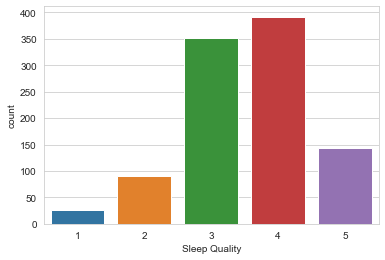

In [154]:
sns.countplot(x="Q10_a", data=sleep)
plt.xlabel('Sleep Quality')

### 2.2.2 Average Hours in Bed Per Day

Text(0.5, 0, 'Average Hours in Bed Per Day')

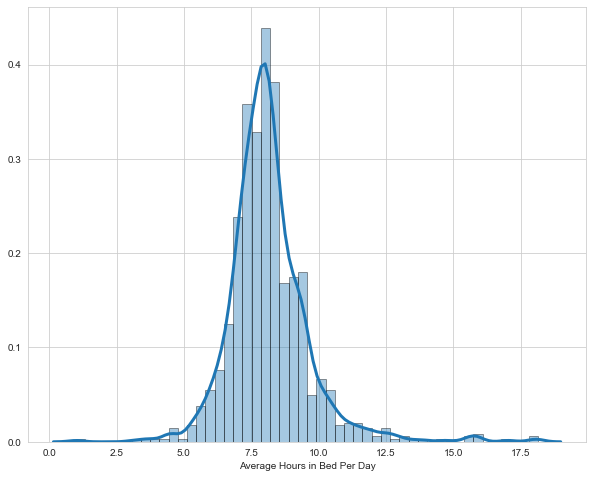

In [156]:
fig = plt.figure(figsize = [10,8])
sns.distplot(sleep.avg_bed, 
             hist = True, kde = True,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})

plt.xlabel('Average Hours in Bed Per Day')

### 2.2.3 Average Actual Sleep Per Day

Text(0.5, 0, 'Average Actual Sleep Per Day')

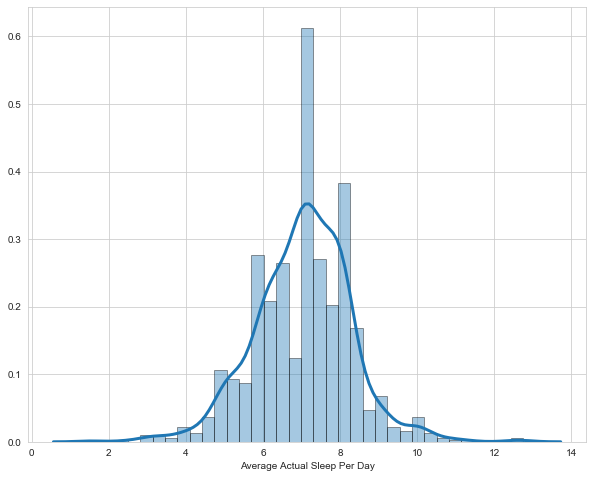

In [157]:
fig = plt.figure(figsize = [10,8])
sns.distplot(sleep.avg_actual_sleep, 
             hist = True, kde = True,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})

plt.xlabel('Average Actual Sleep Per Day')

### 2.2.4 Sleep Efficiency

We decide to use distribution plot to see if there is a pattern in the variable sleep efficiency. And the output graph shows us that the curve is eschewed to the left, most of the people have a sleep efficiency between 0.8 and 1.0.

Text(0.5, 0, 'Sleep Efficiency')

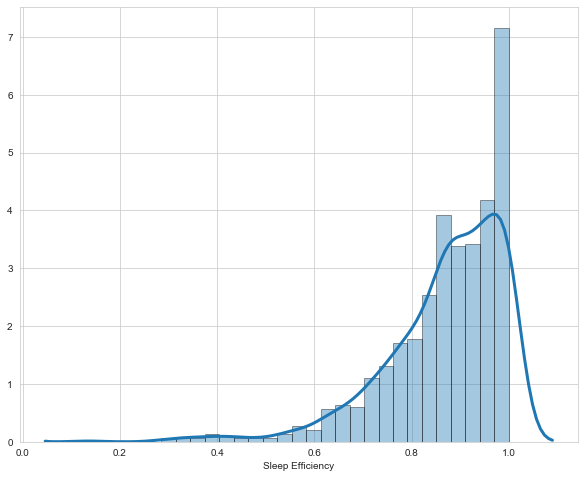

In [158]:
fig = plt.figure(figsize = [10,8])
sns.distplot(sleep.sleep_efficiency, 
             hist = True, kde = True,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})

plt.xlabel('Sleep Efficiency')

While most of the people have sleep efficiency scores larger than 0.8, there still are a lot of people have scores lower than 0.6 or even 0.4. We decide to further investigate the lower outliers in sleep Efficiency. Using IQR, we consider people with sleep efficiency scores less than 0.58 as lower outliers (Q1 - 1.5 IQR). We made side by side comparison for the conut plots of Sleeping Quality for all people and sleeping quality for lower outlier sleep efficiency people. The graph shows that the people with very low sleep efficiency do not have a very extreme distribution in sleeping quality, so we decide to include those people in our data. 

## Sleep Efficiency outlier

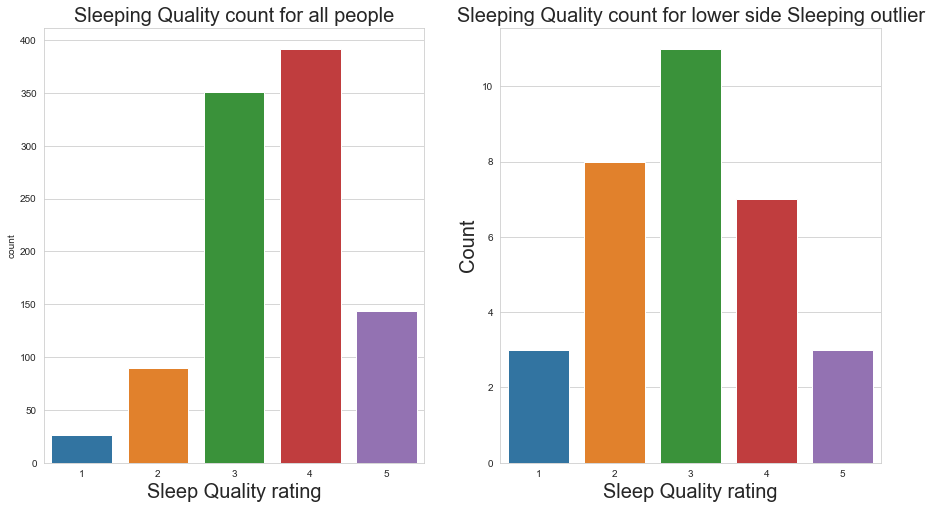

In [212]:
# The count plot of sleeping quality for all of people in the data set
fig = plt.figure(figsize = [15,8])
ax = fig.add_subplot(121)
sns.countplot(x="Q10_a", data=sleep, ax = ax)
plt.title('Sleeping Quality count for all people', fontsize = 20)
plt.xlabel('Sleep Quality rating', fontsize = 20)

# Extract sleep efficiency outliers
eff_Q1 = sleep['sleep_efficiency'].quantile(0.25)
eff_Q3 = sleep['sleep_efficiency'].quantile(0.75)
IQR = eff_Q3 - eff_Q1
eff_outlier_lower = sleep[(sleep.sleep_efficiency <= eff_Q1 - 1.5 * IQR) ]
eff_outlier_lower.head()

## abnormal sleep Efficiency people vs sleeping quality
ax = fig.add_subplot(122)
sns.countplot(x="Q10_a", data=eff_outlier_lower, ax = ax)
plt.xlabel('Sleep Quality rating', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.title('Sleeping Quality count for lower side Sleeping outlier', fontsize = 20);


## Studying upper side and lower side outlier for avg_bed time vs sleeping quality separatly

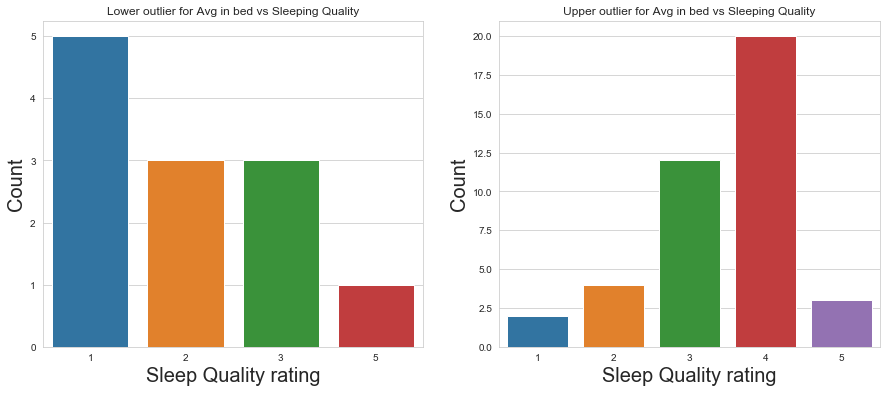

In [160]:
avg_bed_Q1 = sleep['avg_bed'].quantile(0.25)
avg_bed_Q3 = sleep['avg_bed'].quantile(0.75)
avg_bed_IQR = avg_bed_Q3 - avg_bed_Q1
## Only the upper side outlier <= 5.17
avg_bed_outlier_lower = sleep[(sleep.avg_bed <= avg_bed_Q1 - 1.5*avg_bed_IQR)]
avg_bed_outlier_lower.head()
sns.set_style("whitegrid")
fig = plt.figure(figsize = [15,6])

ax = fig.add_subplot(121)
sns.countplot(x="Q10_a", data=avg_bed_outlier_lower, ax = ax)
plt.xlabel('Sleep Quality rating', fontsize = 20)
plt.ylabel('Count', fontsize = 20);
plt.title('Lower outlier for Avg in bed vs Sleeping Quality');
## Only the Upper side outlier >= 10.8
ax = fig.add_subplot(122)
avg_bed_outlier_higher = sleep[(sleep.avg_bed >= avg_bed_Q3 + 1.5*avg_bed_IQR)]
sns.countplot(x="Q10_a", data=avg_bed_outlier_higher, ax = ax)
plt.xlabel('Sleep Quality rating', fontsize = 20)
plt.ylabel('Count', fontsize = 20);
plt.title('Upper outlier for Avg in bed vs Sleeping Quality');

In [161]:
eff_Q1 - 1.5 * IQR

0.5811212015036973

## 2.3 Relationship between Variables

### 2.3.1 Sleep Efficiency & Sleep Quality

From this kernel density estimation plot we see the trend that as the sleep quality score increases the center of the spread in sleep efficiency is higher, in another word, people with 

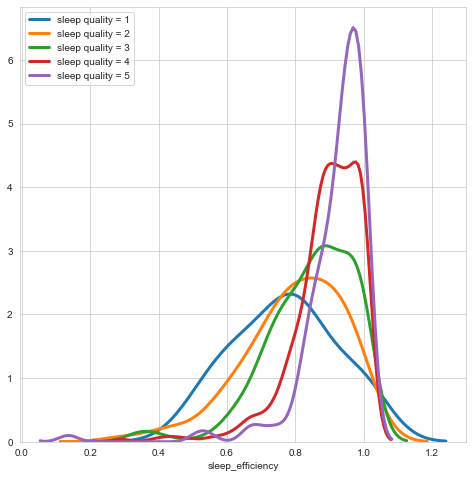

In [231]:
fig = plt.figure(figsize = [8,8])

for i in range(1,6): 
    sns.distplot(sleep.sleep_efficiency.loc[sleep.Q10_a == i], label = 'sleep quality = ' + str(i), hist = False, kde=True, 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
plt.legend();

### 2.3.2 Time Go to Bed & Sleep Efficiency

Text(0.5, 1.0, 'Sleep Efficiency on Weekdays')

Text(0.5, 0, 'Sleep Efficiency')

Text(0.5, 1.0, 'Sleep Efficiency on Weekends')

Text(0.5, 0, 'Sleep Efficiency')

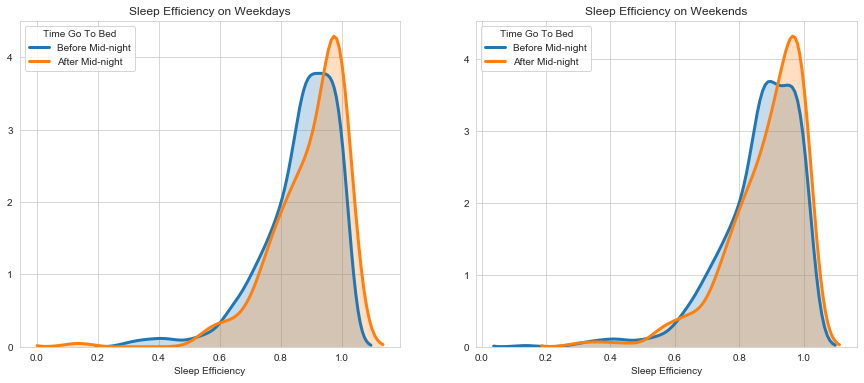

In [163]:
fig = plt.figure(figsize = [15,6])

# Weekdays
ax = fig.add_subplot(121)
sns.distplot(sleep.sleep_efficiency.loc[sleep.before_mnt_week == 'Before Mid-night'], label = 'Before Mid-night', hist = False, kde=True, 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3, "shade": True},
            ax = ax)

sns.distplot(sleep.sleep_efficiency.loc[sleep.before_mnt_week == 'After Mid-night'], label = 'After Mid-night', hist = False, kde=True, 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3, "shade": True},
            ax = ax)

plt.title('Sleep Efficiency on Weekdays')
plt.legend(loc = 'upper left', title = 'Time Go To Bed')
plt.xlabel('Sleep Efficiency')

# Weekends
ax = fig.add_subplot(122)
sns.distplot(sleep.sleep_efficiency.loc[sleep.before_mnt_weekend == 'Before Mid-night'], label = 'Before Mid-night', hist = False, kde=True, 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3, "shade": True},
            ax = ax)

sns.distplot(sleep.sleep_efficiency.loc[sleep.before_mnt_weekend == 'After Mid-night'], label = 'After Mid-night', hist = False, kde=True, 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3, "shade": True},
            ax = ax)
plt.title('Sleep Efficiency on Weekends')
plt.legend(loc = 'upper left',title = 'Time Go To Bed')
plt.xlabel('Sleep Efficiency')

### 2.3.3 Time Go to Bed & Sleep Quality

Text(0.5, 0, 'Sleep Quality')

Text(0, 0.5, 'Percentage')

Text(0.5, 0, 'Sleep Quality')

Text(0, 0.5, 'Percentage')

Text(0.5, 0, 'Time Go to Bed')

Text(0, 0.5, 'Percentage')

Text(0.5, 0, 'Time Go to Bed')

Text(0, 0.5, 'Percentage')

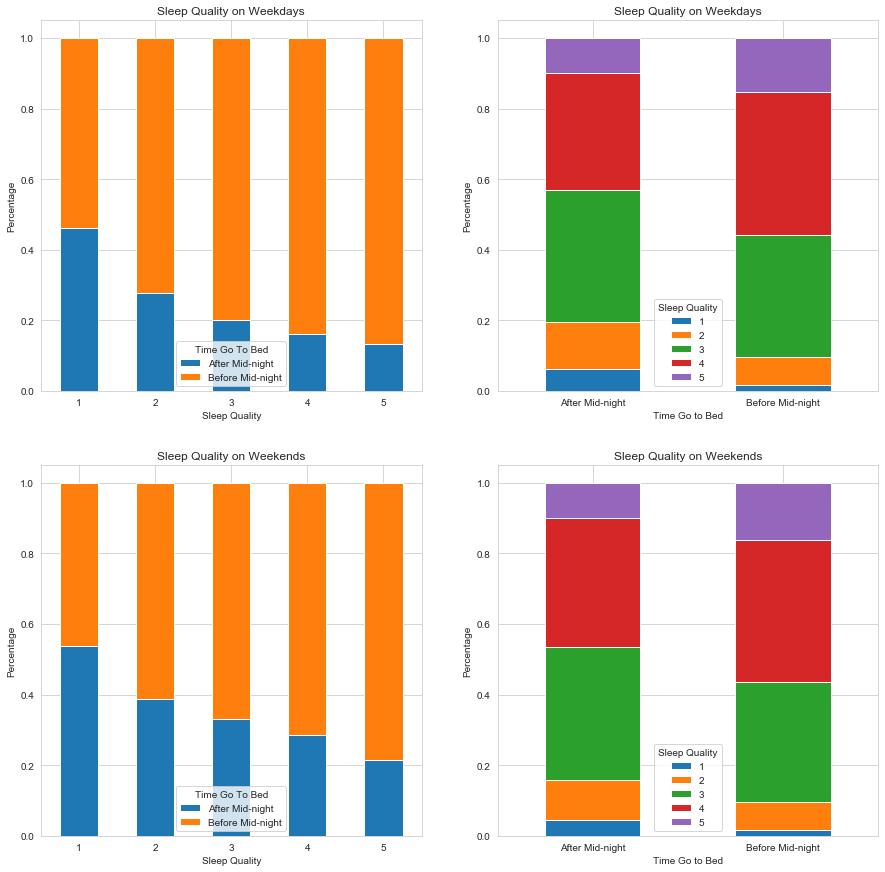

In [164]:
fig = plt.figure(figsize = [15,15])

# Weekdays
ax = fig.add_subplot(221)
bar_data_week = sleep.groupby('Q10_a').before_mnt_week.value_counts(normalize=True).unstack()
bar_data_week.plot(rot=0, kind = 'bar',title = 'Sleep Quality on Weekdays', stacked = True, ax = ax)
plt.legend(title = 'Time Go To Bed')
plt.xlabel('Sleep Quality')
plt.ylabel('Percentage')

# Weekends
ax = fig.add_subplot(223)
bar_data_weekend = sleep.groupby('Q10_a').before_mnt_weekend.value_counts(normalize=True).unstack()
bar_data_weekend.plot(rot=0, kind = 'bar',title = 'Sleep Quality on Weekends', stacked = True, ax = ax)
plt.legend(title = 'Time Go To Bed')
plt.xlabel('Sleep Quality')
plt.ylabel('Percentage')

# Weekdays
ax = fig.add_subplot(222)
bar_data_week2 = sleep.groupby('before_mnt_week').Q10_a.value_counts(normalize=True).unstack()
bar_data_week2.plot(rot=0, kind = 'bar', title = 'Sleep Quality on Weekdays', stacked = True, ax = ax)
plt.legend(title = 'Sleep Quality')
plt.xlabel('Time Go to Bed')
plt.ylabel('Percentage')


# Weekends
ax = fig.add_subplot(224)
bar_data_weekend2 = sleep.groupby('before_mnt_weekend').Q10_a.value_counts(normalize=True).unstack()

bar_data_weekend2.plot(rot=0, kind = 'bar',title = 'Sleep Quality on Weekends', stacked = True, ax = ax)
plt.legend(title = 'Sleep Quality')
plt.xlabel('Time Go to Bed')
plt.ylabel('Percentage')

plt.show()

### 2.3.4 Sleep Disorders & Sleep Quality

Text(0.5, 0, 'Sleep Disorder')

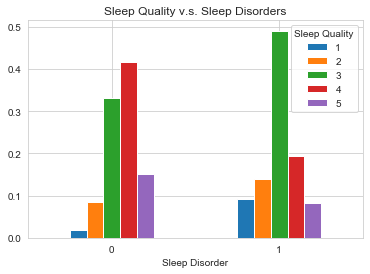

In [165]:
bar_data_disorder = sleep.loc[sleep.Q22_rev != -1].groupby('Q22_rev').Q10_a.value_counts(normalize=True).unstack()

bar_data_disorder.plot(rot=0, kind = 'bar',title = 'Sleep Quality v.s. Sleep Disorders')
plt.legend(title = 'Sleep Quality')
plt.xlabel('Sleep Disorder')

(-0.05, 1.05, -0.05, 1.05)

([<matplotlib.patches.Wedge at 0x1c1dfa7be0>,
 [Text(-1.1852427122778801, 1.287516878721275, 'Apenea'),
  Text(0.7853131019756866, -1.4511317417330947, 'Insomnia'),
  Text(1.5995104048682327, -0.4050511877754005, 'Other')],
 [Text(-0.6772815498730743, 0.7357239306978712, '73.7%'),
  Text(0.42835260107764717, -0.7915264045816879, '18.4%'),
  Text(0.8724602208372176, -0.22093701151385478, '7.9%')])

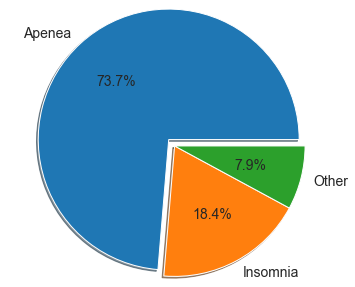

In [166]:
labels = 'Apenea', 'Insomnia', 'Other'
sizes = [sleep['Q23_a'].value_counts()[1], sleep['Q23_b'].value_counts()[1],sleep['Q23_c'].value_counts()[1]]

plt.axis('equal')
plt.pie(sizes, labels=labels, radius=1.5,autopct='%0.1f%%',shadow=True,explode=[0.1,0,0], textprops = {'fontsize': 14})
plt.show()

### 2.3.5 Other Factors Correlated with Sleep Quality

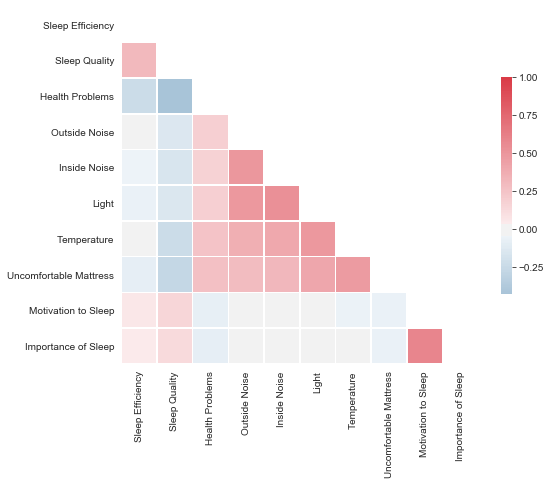

In [167]:
corr_data = sleep.loc[:, ['sleep_efficiency', 'Q10_a','Q14a','Q15_a', 'Q15_b', 'Q15_c', 'Q15_d', 'Q15_e','Q16_rev', 'Q17_rev']]
corr_data.columns = ['Sleep Efficiency', 'Sleep Quality', 'Health Problems', 'Outside Noise', 'Inside Noise', 'Light','Temperature', 'Uncomfortable Mattress', 'Motivation to Sleep', 'Importance of Sleep']

corr = corr_data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
figure, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(600, 10, as_cmap = True)
sns.heatmap(corr, mask = mask, cmap = cmap, center=0,
            square = True, linewidths = .5, cbar_kws={"shrink": .5})

In [168]:
# Number of people with sleeping efficiency < 0.8
sleep.loc[sleep.sleep_efficiency < 0.8].shape

(232, 199)

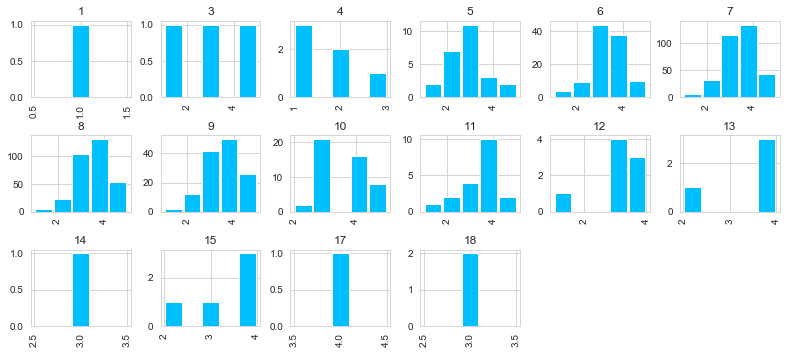

In [169]:
import math
sleep['qua'] = [math.floor(x) for x in sleep.Q10_a]
#sleep.shape
sleep['cat_avg_bed'] = [math.floor(x) for x in sleep.avg_bed]
#sleep.shape
new_sleep = sleep.loc[sleep.Q6_HoursB>=0,['qua','cat_avg_bed']]
#new_sleep.shape
b=new_sleep.hist(column='qua',bins=5,rwidth=0.9,figsize=(13,12),layout=(6,6),by=new_sleep.cat_avg_bed,color=["deepskyblue"])

##  Regression for Sleep Quality and Bedtime

## Decision Tree

In [229]:
#!pip install sklearn
#!pip install pydotplus
import pydotplus
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import export_graphviz

In [ ]:
X = new_sleep.drop(columns = ['quality'])
Y = new_sleep['quality']
# Decision Tree
sleep_train, sleep_test, Quality_train, Quality_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)
# Classsifier with criterion as gini index
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                                  max_depth = 2, min_samples_leaf=5)


clf_gini.fit(sleep_train, Quality_train)
Quality_pred = clf_gini.predict(sleep_test)
Quality_pred
accuracy_score(Quality_test,Quality_pred)*100
# Classifier with criterion information gain

clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
 max_depth=3, min_samples_leaf=5)
clf_entropy.fit(sleep_train, Quality_train)
y_pred_en = clf_entropy.predict(sleep_test)
y_pred_en
accuracy_score(Quality_test,y_pred_en)*100
# Visualize data
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = tree.export_graphviz(clf_gini,                    
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [171]:
new_sleep= sleep[['sleep_efficiency','avg_bed',"avg_actual_sleep",'Q10_a','before_mnt_week',"before_mnt_weekend","Q22_rev",'Q16_rev',"Q17_rev","Q15_a","Q15_b","Q15_c","Q15_d","Q15_e"]]
new_sleep.head(10)
new_sleep.columns=['efficiency','avg_bedtime',"avg_actual_sleeptime","quality",'weekday_midnight',"weekend_midnight","disorder","motivation","ontime_bed","outside_noise","inside_noise","light","temperature","mattress"]
new_sleep=new_sleep.loc[new_sleep.disorder!=-1,]
new_sleep=new_sleep.loc[new_sleep.light!=7,]
new_sleep=new_sleep.loc[new_sleep.motivation!=7,]
new_sleep=new_sleep.loc[new_sleep.ontime_bed!=7,]
new_sleep=new_sleep.loc[new_sleep.inside_noise!=7,]
new_sleep=new_sleep.loc[new_sleep.mattress!=7,]

new_sleep.weekday_midnight=new_sleep['weekday_midnight'].replace(['Before Mid-night'],1)
new_sleep.weekday_midnight=new_sleep['weekday_midnight'].replace(['After Mid-night'],0)
new_sleep.weekday_midnight.value_counts()
new_sleep.weekend_midnight=new_sleep['weekend_midnight'].replace(['Before Mid-night'],1)
new_sleep.weekend_midnight=new_sleep['weekend_midnight'].replace(['After Mid-night'],0)
new_sleep.weekend_midnight.value_counts()
new_sleep.shape
new_sleep.head(3)

X = new_sleep.drop(columns = ['quality'])
Y = new_sleep['quality']

,sleep_efficiency,avg_bed,avg_actual_sleep,Q10_a,before_mnt_week,before_mnt_weekend,Q22_rev,Q16_rev,Q17_rev,Q15_a,Q15_b,Q15_c,Q15_d,Q15_e
0,0.605970,11.964286,7.250000,4,Before Mid-night,Before Mid-night,0,3,4,2,1,1,3,1
1,0.888889,9.000000,8.000000,4,Before Mid-night,Before Mid-night,0,4,3,3,2,2,3,2
2,0.957265,8.357143,8.000000,4,Before Mid-night,Before Mid-night,0,5,5,1,1,1,2,1
3,0.892857,8.000000,7.142857,2,Before Mid-night,After Mid-night,0,4,3,1,1,2,2,1
4,1.000000,7.500000,7.500000,4,Before Mid-night,Before Mid-night,0,3,3,1,1,1,1,1
5,0.808081,7.071429,5.714286,5,Before Mid-night,After Mid-night,0,5,4,1,1,1,1,1
6,0.727273,11.000000,8.000000,3,Before Mid-night,Before Mid-night,0,4,3,1,1,1,2,4
7,0.786070,7.178571,5.642857,3,Before Mid-night,Before Mid-night,0,4,4,1,1,1,2,1
8,0.921811,8.678571,8.000000,4,Before Mid-night,Before Mid-night,1,4,4,1,1,1,1,1
9,0.888889,9.000000,8.000000,3,Before Mid-night,Before Mid-night,0,3,3,2,3,3,3,2


1    803
0    188
Name: weekday_midnight, dtype: int64

1    685
0    306
Name: weekend_midnight, dtype: int64

(991, 14)

,efficiency,avg_bedtime,avg_actual_sleeptime,quality,weekday_midnight,weekend_midnight,disorder,motivation,ontime_bed,outside_noise,inside_noise,light,temperature,mattress
0,0.605970,11.964286,7.25,4,1,1,0,3,4,2,1,1,3,1
1,0.888889,9.000000,8.00,4,1,1,0,4,3,3,2,2,3,2
2,0.957265,8.357143,8.00,4,1,1,0,5,5,1,1,1,2,1


(991, 14)

In [172]:
# Decision Tree
sleep_train, sleep_test, Quality_train, Quality_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)

In [215]:
# Classsifier with criterion as gini index
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                                  max_depth = 2, min_samples_leaf=5)


clf_gini.fit(sleep_train, Quality_train)
Quality_pred = clf_gini.predict(sleep_test)
Quality_pred
accuracy_score(Quality_test,Quality_pred)*100

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=100, splitter='best')

array([4, 3, 4, 2, 3, 3, 3, 4, 4, 3, 4, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3,
       2, 4, 2, 3, 2, 4, 2, 4, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 4, 4, 4, 2,
       4, 2, 3, 4, 4, 3, 4, 4, 3, 4, 4, 4, 4, 3, 3, 3, 3, 2, 4, 4, 4, 4,
       4, 4, 3, 4, 4, 2, 4, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 4, 2, 3, 4,
       3, 3, 4, 4, 3, 3, 3, 4, 3, 2, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 2, 3, 3, 3, 4, 3, 4, 3, 4, 4, 3, 4, 3, 3, 4, 4, 4, 3,
       3, 3, 3, 4, 4, 3, 3, 3, 3, 2, 4, 4, 4, 4, 4, 3, 3, 4, 4, 3, 3, 4,
       2, 2, 3, 4, 4, 3, 3, 3, 4, 4, 3, 4, 4, 4, 3, 4, 3, 4, 3, 3, 3, 3,
       4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 2, 3, 3, 4, 4, 3, 2, 3, 3, 4, 3, 4,
       4, 4, 2, 4, 3, 4, 3, 3, 4, 4, 3, 4, 4, 4, 3, 3, 4, 3, 2, 4, 3, 3,
       4, 4, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 4, 3, 3, 3, 2, 3, 3, 3, 3, 2,
       4, 3, 4, 3, 3, 2, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 3,
       3, 2, 4, 3, 4, 3, 4, 3, 4, 3, 4, 4, 3, 4, 2, 3, 3, 3, 3, 4, 3, 4,
       4, 2, 3, 3, 3, 3, 4, 3, 3, 2, 3, 3])

44.63087248322148

/bin/sh: brew: command not found


In [216]:
# Classifier with criterion information gain

clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
 max_depth=3, min_samples_leaf=5)
clf_entropy.fit(sleep_train, Quality_train)
y_pred_en = clf_entropy.predict(sleep_test)
y_pred_en
accuracy_score(Quality_test,y_pred_en)*100


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=100, splitter='best')

array([4, 3, 4, 2, 4, 4, 5, 4, 4, 3, 4, 4, 4, 3, 4, 4, 3, 3, 4, 3, 4, 4,
       2, 4, 2, 3, 2, 4, 3, 4, 4, 3, 4, 2, 4, 4, 2, 3, 3, 2, 4, 4, 4, 2,
       4, 3, 4, 4, 5, 3, 4, 4, 3, 4, 4, 4, 4, 4, 3, 3, 4, 3, 4, 5, 4, 4,
       4, 4, 3, 4, 5, 3, 4, 3, 3, 4, 4, 5, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4,
       5, 4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 5, 4, 3, 4, 4, 3, 4, 3, 4, 4, 4,
       4, 4, 4, 4, 2, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 5, 4,
       2, 2, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 3, 3, 3,
       4, 4, 3, 3, 3, 4, 4, 4, 3, 4, 2, 3, 3, 4, 4, 3, 3, 4, 3, 4, 4, 4,
       4, 4, 2, 4, 3, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4,
       5, 4, 3, 3, 3, 4, 4, 4, 3, 3, 4, 3, 4, 3, 4, 4, 2, 4, 4, 4, 3, 2,
       4, 3, 4, 4, 3, 3, 4, 4, 4, 4, 4, 3, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 3, 4, 3, 4, 3, 4, 4, 4,
       5, 2, 4, 3, 3, 3, 4, 4, 3, 2, 4, 3])

48.65771812080537

In [226]:
# Visualize data
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = tree.export_graphviz(clf_gini,                    
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())



InvocationException: GraphViz's executables not found

In [225]:





from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

AttributeError: 'DataFrame' object has no attribute 'target'